## 타이타닉 생존자 예측 분류기 평가

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


#### 1. 데이터 전처리

- Feature selection: 중복 필드 제거

In [3]:
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'who', 'deck']]
df.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,deck
886,0,2,male,27.0,0,0,13.00,S,man,NaN
887,1,1,female,19.0,0,0,30.00,S,woman,B
888,0,3,female,NaN,1,2,23.45,S,woman,NaN
889,1,1,male,26.0,0,0,30.00,C,man,C
890,0,3,male,32.0,0,0,7.75,Q,man,NaN


- 결측치 처리

In [4]:
# 어느 컬럼에 결측치가 있는지 확인
df.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
who           0
deck        688
dtype: int64

In [5]:
df.who.unique()

array(['man', 'woman', 'child'], dtype=object)

In [6]:
df.who.value_counts()

man      537
woman    271
child     83
Name: who, dtype: int64

In [7]:
# man, woman, child 각각 age 컬럼이 결측치가 있는지 확인
df.age[df.who == 'man'].isna().sum(), df.age[df.who == 'woman'].isna().sum(), df.age[df.who == 'child'].isna().sum()
# 성인 남여에는 결측치가 있지만, 아동에는 결측치가 없음

(124, 53, 0)

In [8]:
# age - man, woman의 평균으로 대체
df.age.fillna(df[df.who.isin(['man', 'woman'])].age.mean().round(1), inplace=True)

In [9]:
df.age.isna().sum()

0

In [10]:
# embarked 결측치는 최빈값으로 대체
df.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [11]:
# df.emberked.fillna(df.embarked.value_counts().index[0], inplace=True)
df.embarked.fillna('S', inplace=True)

In [12]:
# S라는 것을 눈으로 볼 수 없을때 이렇게 찾기도 함
df.embarked.value_counts().index[0]

'S'

In [13]:
# deck 컬럼 삭제(결측치가 너무 많아서), who 컬럼도 삭제(age와 중복)
df.drop(columns=['deck', 'who'], inplace=True)

In [14]:
# 최종 확인(isna() 결측치 있는지 확인)
df.isna().sum().sum()

0

- 카테고리형 데이터를 숫자로 변환

In [15]:
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [17]:
df.sex = le.fit_transform(df.sex)
df.embarked = le.fit_transform(df.embarked)
df.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
886,0,2,1,27.0,0,0,13.00,2
887,1,1,0,19.0,0,0,30.00,2
888,0,3,0,32.8,1,2,23.45,2
889,1,1,1,26.0,0,0,30.00,0
890,0,3,1,32.0,0,0,7.75,1


#### 2. 훈련/테스터 데이터셋 분리

In [18]:
# y = survived, X = 나머지 칼럼들
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values                # df.survived.values도 가능

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=2023
)

#### 3. 학습
- Random Forest: Decision Tree 100개            (앙상블 학습)
- Grid Search CV

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=2023)
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2023,
 'verbose': 0,
 'warm_start': False}

In [21]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [4, 7, 10], 'min_samples_split':[2, 3, 4]}
grid_rf = GridSearchCV(rfc, params, scoring='accuracy', cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2023),
             param_grid={'max_depth': [4, 7, 10],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy')

In [22]:
grid_rf.best_params_

{'max_depth': 4, 'min_samples_split': 3}

In [23]:
rfc = RandomForestClassifier(random_state=2023)
params = {'max_depth': [3, 4, 5, 6], 'min_samples_split':[2, 3, 4]}
grid_rf = GridSearchCV(rfc, params, scoring='accuracy', cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2023),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy')

In [24]:
grid_rf.best_params_

{'max_depth': 6, 'min_samples_split': 4}

#### 4. 예측 및 평가

In [25]:
best_rf = grid_rf.best_estimator_
pred = best_rf.predict(X_test)
rf = pd.DataFrame({'y 실제값': y_test, 'y 예측값':pred})
rf.head()

,y 실제값,y 예측값
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


In [33]:
best_rf.score(X_test, y_test)

0.3854748603351955

#### 5. 엉터리 분류기

- 여성이면 생존이라 예측하고, 남성이면 사망이라 예측

In [35]:
df.pivot_table('survived', 'sex')

,survived
sex,
0,0.742038
1,0.188908


In [37]:
# 두번째 열 - 1이면 남성, 0이면 여성
X[:3]

array([[ 3.    ,  1.    , 22.    ,  1.    ,  0.    ,  7.25  ,  2.    ],
       [ 1.    ,  0.    , 38.    ,  1.    ,  0.    , 71.2833,  0.    ],
       [ 3.    ,  0.    , 26.    ,  0.    ,  0.    ,  7.925 ,  2.    ]])

In [38]:
X_train.shape, X_test.shape

((712, 7), (179, 7))

- 엉터리 분류기 제작

In [39]:
from sklearn.base import BaseEstimator

# BaseEstimator를 상속해서 MyClassifier 클래스를 만들고
# fit(), predict() method 재정의
# 여성이면 생존, 남성이면 사망이라고 예측
class MyClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X):
        pred = np.zeros(X.shape[0], int)
        for i in range(X.shape[0]):
            if X[i, 1] == 0.:       # 여성이면
                pred[i] = 1         # 생존으로 지정
        return pred

In [40]:
myc = MyClassifier()
myc.fit(X_train, y_train)
pred_my = myc.predict(X_test)

In [41]:
rf['엉터리 예측'] = pred_my
rf.head()

,y 실제값,y 예측값,엉터리 예측
0,0,0,0
1,1,1,1
2,0,0,0
3,0,0,0
4,0,0,0


In [42]:
# 정확도
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_my)

0.7653631284916201

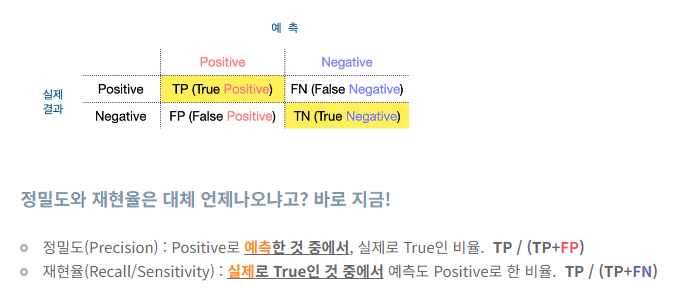


#### 6. 오차 행렬(Confusion matrix)

- 오차행렬(confusion matrix)은 실제로 참(True)인지 거짓(False)인지, 예측을 긍정(Positive)으로  했는지, 부정(Negative)으로 했는지에 따라 네 개의 경우의 수로 구분한 표

In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [44]:
# 오차 행렬 - Random Forest Classifier
confusion_matrix(y_test, pred)

array([[97, 13],
       [21, 48]], dtype=int64)

In [45]:
# 오차 행렬 - 엉터리 분류기
confusion_matrix(y_test, pred_my)

array([[88, 22],
       [20, 49]], dtype=int64)

In [46]:
# 정확도 - RFC vs MyC
accuracy_score(y_test, pred), accuracy_score(y_test, pred_my)

(0.8100558659217877, 0.7653631284916201)

In [47]:
# 정밀도(Precision, 1종 오류)
precision_score(y_test, pred), precision_score(y_test, pred_my)

(0.7868852459016393, 0.6901408450704225)

In [48]:
# 재현율(Recall, 2종 오류)
recall_score(y_test, pred), recall_score(y_test, pred_my)

(0.6956521739130435, 0.7101449275362319)

In [49]:
# F1 score(정밀도와 재현율의 조화 평균)
from sklearn.metrics import f1_score
f1_score(y_test, pred), f1_score(y_test, pred_my)

(0.7384615384615385, 0.7)

In [50]:
# ROC AUC(Area under curve) score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred), roc_auc_score(y_test, pred_my)

(0.7887351778656126, 0.755072463768116)